In [20]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv




# !! handle the star / galaxy separation
## Try with SN-C3 

In [2]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


# Catalog
fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table
t=join(t,t3,keys='id') 
#t.rename_column('ra_1','ra')
#t.rename_column('dec_1','dec')
t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')



#!!! remove stars 
t = t[t['kNN_class'] != 2]
# Our main star / galaxy separation method in the DES DF is a kNN classifier, with the catalogue column kNN_CLASS. We should discard objects with values of 2.
# But that won't remove all stars, so we also want to use a compactness cut

# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog



In [3]:
t['kNN_class']

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [4]:
print(t.colnames)

print(type(t))


['id', 'z', 'SM', 'z_pcntiles', 'z_pdf', 'ra', 'dec', 'fof_id', 'fof_size', 'mask_flags', 'flags', 'flagstr', 'badpix_frac', 'psf_g_0', 'psf_g_1', 'psf_T', 'bdf_T', 'bdf_T_err', 'bdf_T_ratio', 'bdf_g_0', 'bdf_g_1', 'bdf_fracdev', 'bdf_fracdev_err', 'tilename', 'EBV_SFD98', 'mask_flags_nir', 'flags_nir', 'flagstr_nir', 'badpix_frac_nir', 'psf_flux_u', 'psf_flux_g', 'psf_flux_r', 'psf_flux_i', 'psf_flux_z', 'psf_flux_J', 'psf_flux_H', 'psf_flux_Ks', 'psf_flux_err_u', 'psf_flux_err_g', 'psf_flux_err_r', 'psf_flux_err_i', 'psf_flux_err_z', 'psf_flux_err_J', 'psf_flux_err_H', 'psf_flux_err_Ks', 'bdf_flux_u', 'bdf_flux_g', 'bdf_flux_r', 'bdf_flux_i', 'bdf_flux_z', 'bdf_flux_J', 'bdf_flux_H', 'bdf_flux_Ks', 'bdf_flux_err_u', 'bdf_flux_err_g', 'bdf_flux_err_r', 'bdf_flux_err_i', 'bdf_flux_err_z', 'bdf_flux_err_J', 'bdf_flux_err_H', 'bdf_flux_err_Ks', 'gap_flux_u', 'gap_flux_g', 'gap_flux_r', 'gap_flux_i', 'gap_flux_z', 'gap_flux_J', 'gap_flux_H', 'gap_flux_Ks', 'gap_flux_err_u', 'gap_flux_err_

In [5]:
print(t['psf_mag_dered_calib_i'])

psf_mag_dered_calib_i
---------------------
   24.334646753542877
   25.360745915348502
   20.716085898141817
    25.25089804540787
   25.648298035751793
   23.180468003033788
   26.035623081267012
   22.297118410980847
   22.524811936700956
   23.632215793729827
                  ...
   24.942420042010042
   25.939419676484174
     25.6943492680788
   26.387592254522847
   25.076662828340474
   26.116525480847038
    26.06020743147967
    26.10806940304986
   24.004612517723412
   26.005863658511156
Length = 314615 rows


In [6]:
delta_mag = t['bdf_mag_dered_calib_i'] - t['psf_mag_dered_calib_i']


In [7]:
print(len(delta_mag ) )
print(len(t['bdf_mag_dered_calib_i'] ) )

314615
314615


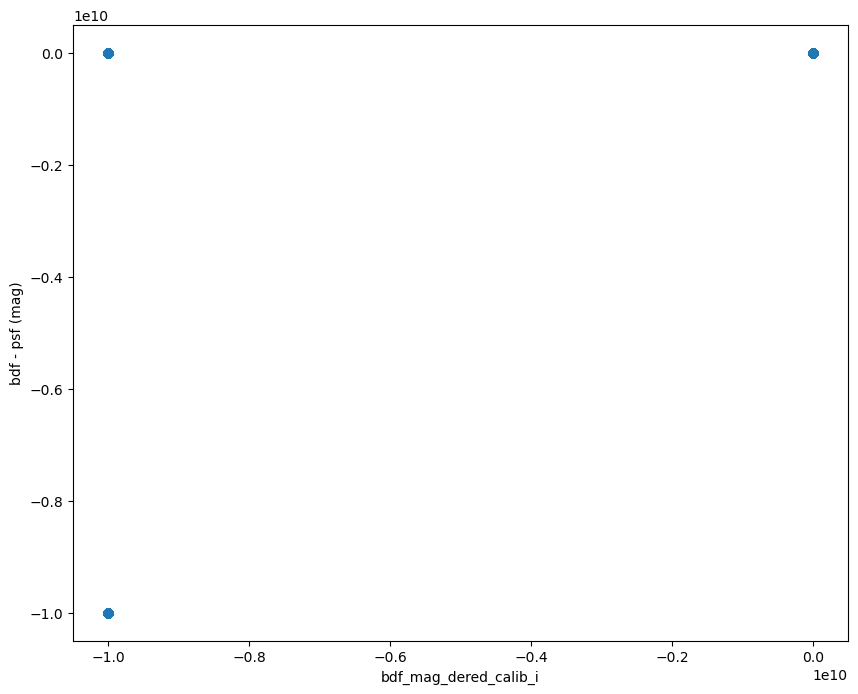

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(t['bdf_mag_dered_calib_i'], delta_mag)
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.show()

### ^ you can see that galaxies tend to have negative values in the magnitude difference axis (they're brighter in the bulge+disk model fit than PSF fit photometry) and stars have values ~0. So we want to define a cut in bdf - psf mag that removes compact objects that are not flagged by kNN_CLASS. 

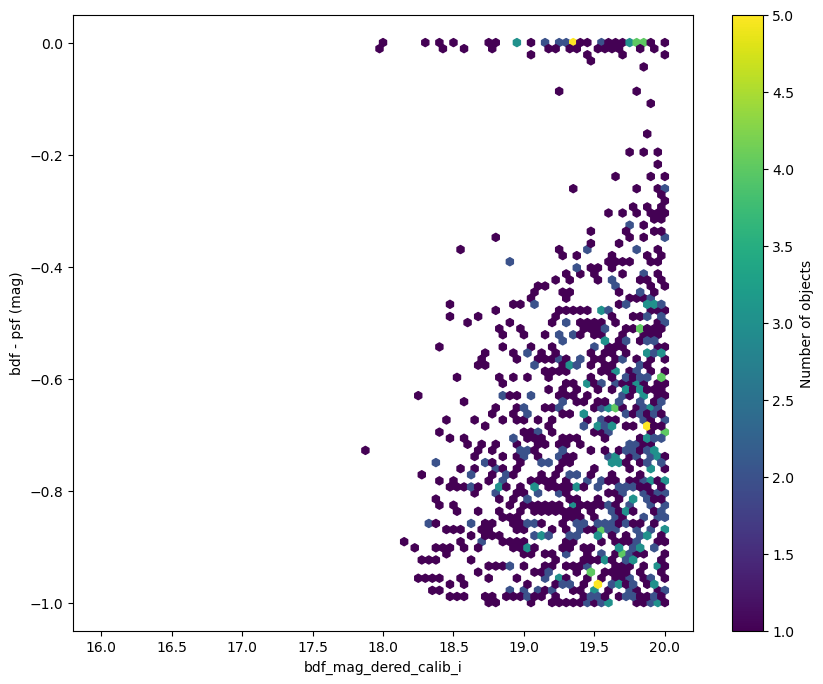

In [9]:
plt.figure(figsize=(10,8))
plt.hexbin( t['bdf_mag_dered_calib_i'], delta_mag, gridsize=80, cmap='viridis', mincnt=1, extent=(16,20, -1,0))
plt.colorbar(label='Number of objects')
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.show()



In [10]:
print(len(np.where((t['bdf_mag_dered_calib_i']<22) & (delta_mag > -0.02))[0]))

661


In [11]:
# Check flagged objects
flagged_mask = (t['flags'] > 0) | (t['flags_nir'] > 0)  # flags>0 or flags_nir>0 

n_flagged = np.sum(flagged_mask)
n_total = len(t)
# what fraction of objects have flags>0 or flags_nir>0 after cross-matching with the masked cat
fraction_flagged = n_flagged / n_total

print(f"Number of objects flagged: {n_flagged}/{n_total}")
print(f"Fraction of flagged objects: {fraction_flagged:.3%}")


Number of objects flagged: 3204/314615
Fraction of flagged objects: 1.018%


#### If it's a small fraction (a few percent), then we can exclude them. We might need to anyway, they might not have valid values for the fluxes etc., so then it's just good to know how many there are. In the worst case we can run the measurements with and without them to test the sensitivity to that. Some of the objects are flagged due to fitting failures, and the risk is that those are more common in densely-populated regions, which is obviously going to affect our clustering measurements.

In [12]:
z_min, z_max = 0.3, 0.6
SM_min, SM_max = 10, 12.5
# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}


In [13]:
sub1 = dv.Selection(t,randoms,z_min,z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


<>:37: SyntaxWarning: invalid escape sequence '\i'
<>:37: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2234126/1639475363.py:37: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


HOD fit results: M_min = 10^12.25, M_1 = 10^13.59, alpha = 1.14


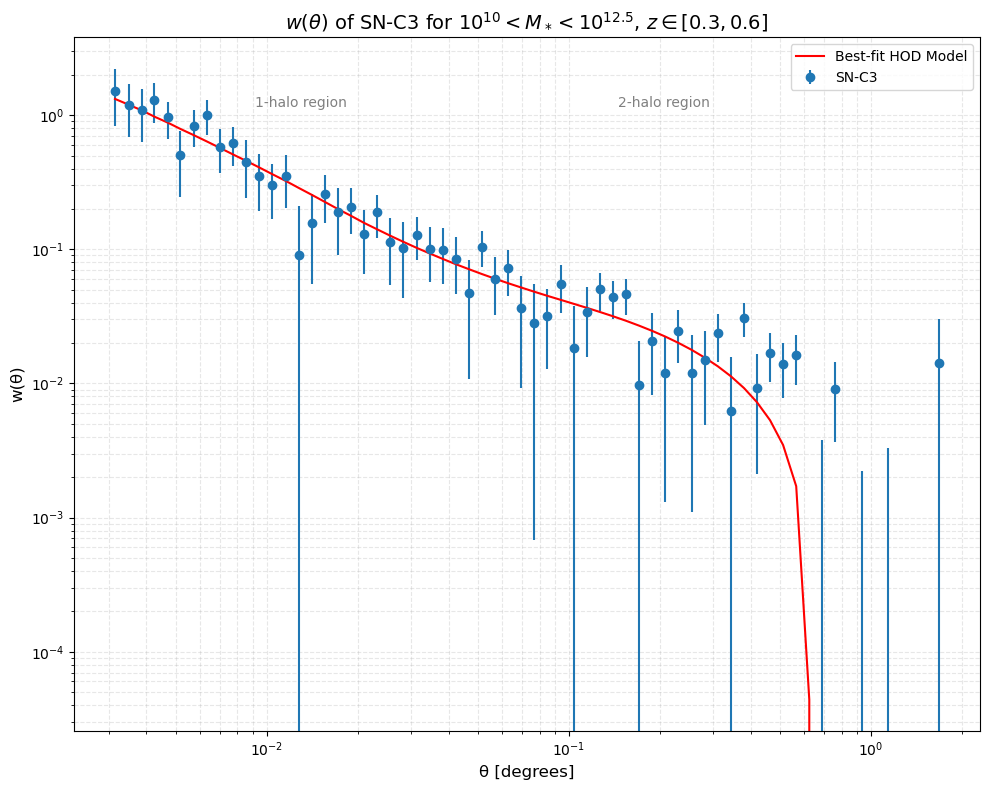

In [14]:

# Fit HOD with custom bounds
#hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds = ([11.0*1e-7, 12.5, 0.99], [14.5*1e-7, 15.5, 1.01]) # fix alpha to 1
hod_params, pcov = sub1.fit_hod(p0=[12.3*1e-7, 13.5, 1.0]) 


results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

# Model prediction with best-fit parameters
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')

plt.savefig(f"wtheta_SN_C3_HOD_SM_{SM_min}_{SM_max}_{z_min}_{z_max}.png")

plt.tight_layout()
plt.show()

In [15]:
def load_and_clean_catalog(path, compactness_cut=0):
    """
    Read a FITS catalog and apply star/galaxy separation and flag cleaning.

    """
    cat = Table.read(path)

    # Remove stars 
    if 'kNN_class' in cat.colnames:
        cat = cat[cat['kNN_class'] != 2]

    # Compactness cut: Δm = bdf - psf 
    bdf_col = 'bdf_mag_dered_calib_i'
    psf_col = 'psf_mag_dered_calib_i'
    if bdf_col in cat.colnames and psf_col in cat.colnames:
        delta_mag = cat[bdf_col] - cat[psf_col]
        cat = cat[delta_mag < compactness_cut]

    return cat

def exclude_flagged_objects(cat):
    """
    Exclude objects with flags > 0 or flags_nir > 0.

    """
    flagged_mask = np.zeros(len(cat), dtype=bool)
    if 'flags' in cat.colnames:
        flagged_mask |= cat['flags'] > 0
    if 'flags_nir' in cat.colnames:
        flagged_mask |= cat['flags_nir'] > 0

    return cat[~flagged_mask]

fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")
t = load_and_clean_catalog(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")
t3 = load_and_clean_catalog(masked_file_path)
t = join(t, t3, keys='id')
t.rename_column('mode_z', 'z')
t.rename_column('mode_mass', 'SM')
t = exclude_flagged_objects(t)

fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits")
randoms = load_and_clean_catalog(fits_random)
randoms = exclude_flagged_objects(randoms)

print(f"Cleaned science catalog: {len(t)} objects")
print(f"Cleaned random catalog: {len(randoms)} objects")

Cleaned science catalog: 271783 objects
Cleaned random catalog: 13402307 objects


# Now all my DF DES catalogues

In [29]:
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

### Combine data and fit simultanously

In [30]:
class MultiFieldHODFitter:
    def __init__(self, selections):
        self.selections = selections
        
        theta0 = selections[0].theta
        for sel in selections:
            assert np.allclose(sel.theta, theta0), "All selections must share the same theta grid"

        self.theta = theta0
        self.mask = (self.theta >= 0.004) & (self.theta <= 0.4)

    def _combined_model(self, theta, logM_min, logM_1, alpha):
        model_vals = []
        for sel in self.selections:
            model = sel.hod_model(logM_min * 1e7, logM_1, alpha)[self.mask]
            model_vals.append(model)
        return np.concatenate(model_vals)

    def _combined_data(self):
        w_obs_all = []
        w_err_all = []

        for sel in self.selections:
            w = sel.w_theta[self.mask]
            err = np.sqrt(sel.var_w_theta_bootstrap[self.mask])
            w_obs_all.append(w)
            w_err_all.append(err)

        return np.concatenate(w_obs_all), np.concatenate(w_err_all)

    def fit(self, p0=None, bounds=None):
        if p0 is None:
            p0 = [12.3 * 1e-7, 13.5, 1.0]
        if bounds is None:
            bounds = ([11.0 * 1e-7, 12.5, 0.3], 
                      [14.5 * 1e-7, 15.5, 2.0])

        w_obs, w_err = self._combined_data()

        popt, pcov = curve_fit(
            self._combined_model,
            self.theta[self.mask],
            w_obs,
            sigma=w_err,
            p0=p0,
            bounds=bounds,
            maxfev=20000
        )

        for sel in self.selections:
            sel.hod_params = popt
            sel.xi_g = sel.hod_model(popt[0] * 1e7, popt[1], popt[2])

        return popt, pcov

In [31]:
def plot_joint_fit(field_selections, colors, SM_min, SM_max, shared_theta):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2.5, 1]})

    for sel in field_selections:
        #field = sel.info.get('field_name', {field})
        field = sel.info.get('field_name', 'unknown')

        theta = sel.theta
        mask = (theta >= 0.004) & (theta <= 0.4)
        color = colors.get(field, 'black')

        w_obs = sel.w_theta
        w_model = sel.xi_g
        err = np.sqrt(sel.var_w_theta_bootstrap)

        ax1.errorbar(theta, w_obs, yerr=err, fmt='o', label=f'{field} (data)', color=color)
        ax1.plot(theta, w_model, linestyle='--', color=color, label=f'{field} (model)')

        res = (w_obs - w_model) / err
        ax2.plot(theta[mask], res[mask], marker='o', color=color, label=field)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$w(\theta)$', fontsize=14)
    ax1.set_title(f'Joint HOD Fit — log M* ∈ [{SM_min}, {SM_max}]', fontsize=15)
    ax1.legend()
    ax1.grid(True, which="both", ls="--", alpha=0.3)

    ax2.axhline(0, color='black', ls='--')
    ax2.axhline(1, color='gray', ls=':', alpha=0.5)
    ax2.axhline(-1, color='gray', ls=':', alpha=0.5)
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$\theta$ [deg]', fontsize=14)
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.grid(True, which="both", ls="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

### First compare SHMR with Shuntov +22 (z is  0.2, 0.5 and SM_bins = [(8.5, 12.5), (9.5,12.5), (10.5, 12.5)])

In [32]:

# Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

z_min, z_max = 0.2, 0.5
SM_bins = [(8.5, 12.5), (9.5,12.5), (10.5, 12.5)]


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



## Use the SBI outputs!!!
fields = {
    "SN-X3": {
        "catalog": "DES_DF_SN-X3_sbi_output.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "DES_DF_SN-C3_sbi_output.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "DES_DF_SN-E2_sbi_output.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "DES_DF_COSMOS_sbi_output.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}


colors = {
    "SN-C3":  "tab:blue",
    "SN-X3":  "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2":  "tab:green"
}

In [37]:
def load_catalog(path):
    cat = Table.read(path)

    # Safely lowercase all column names
    old_cols = list(cat.colnames)
    new_cols = [c.lower() for c in old_cols]
    cat.rename_columns(old_cols, new_cols)

    return cat


def remove_stars(cat, compactness_cut=-0.02):
    if 'knn_class' in cat.colnames:
        cat = cat[cat['knn_class'] != 2]

    bdf = 'bdf_mag_dered_calib_i'
    psf = 'psf_mag_dered_calib_i'
    if bdf in cat.colnames and psf in cat.colnames:
        delta = cat[bdf] - cat[psf]
        cat = cat[delta < compactness_cut]

    return cat

def remove_flagged(cat):
    mask = np.ones(len(cat), bool)
    if 'flags' in cat.colnames:
        mask &= cat['flags'] == 0
    if 'flags_nir' in cat.colnames:
        mask &= cat['flags_nir'] == 0
    return cat[mask]

def clean_catalog(path):
    cat = load_catalog(path)
    cat = remove_stars(cat, compactness_cut=-0.02)
    cat = remove_flagged(cat)
    return cat




🔹 Processing stellar mass bin 8.5–12.5


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)



🔸 Processing field: SN-X3

🔸 Processing field: SN-C3



🔸 Processing field: SN-E2

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 12.11, logM_1 = 13.81, alpha = 1.01


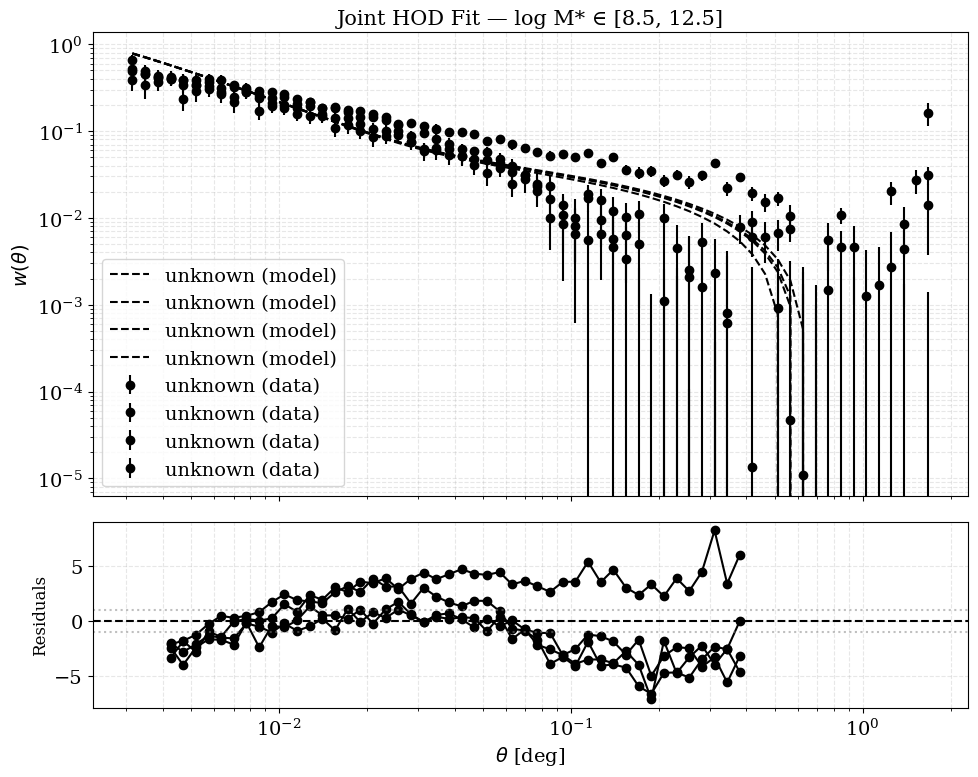



🔹 Processing stellar mass bin 9.5–12.5

🔸 Processing field: SN-X3

🔸 Processing field: SN-C3

🔸 Processing field: SN-E2
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 12.50, logM_1 = 14.18, alpha = 1.01


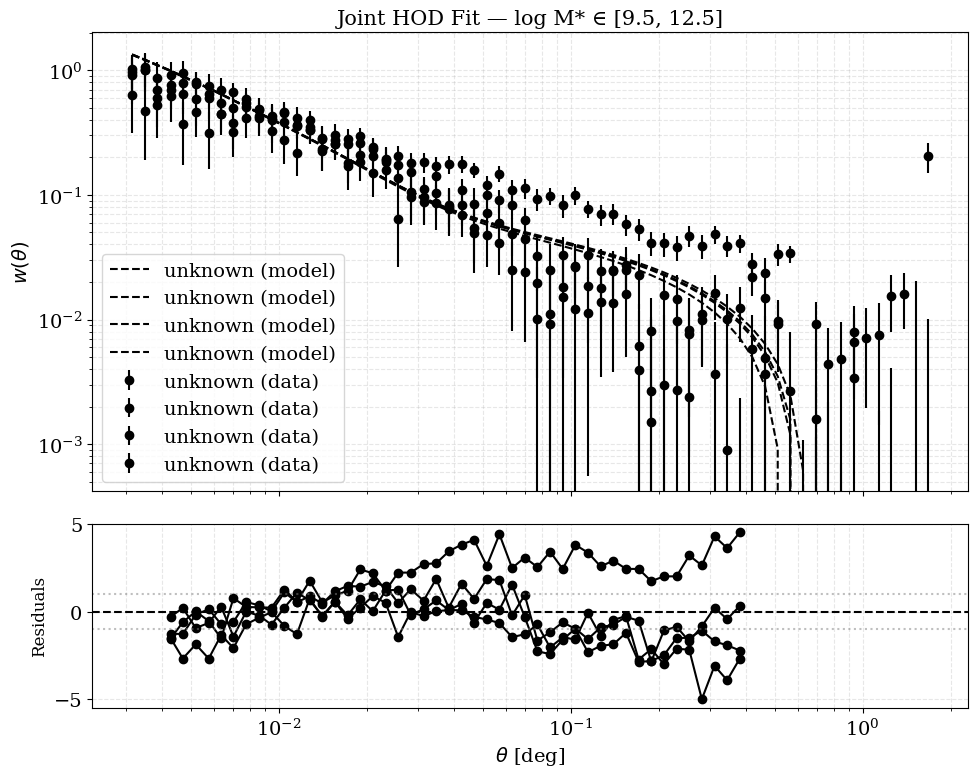



🔹 Processing stellar mass bin 10.5–12.5

🔸 Processing field: SN-X3

🔸 Processing field: SN-C3

🔸 Processing field: SN-E2
The following patch numbers have no objects: {7}
This may be a problem depending on your use case.
The following patch numbers have no objects: {11}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.

🔸 Processing field: COSMOS

✅ Joint HOD best-fit: logM_min = 12.82, logM_1 = 14.55, alpha = 1.01


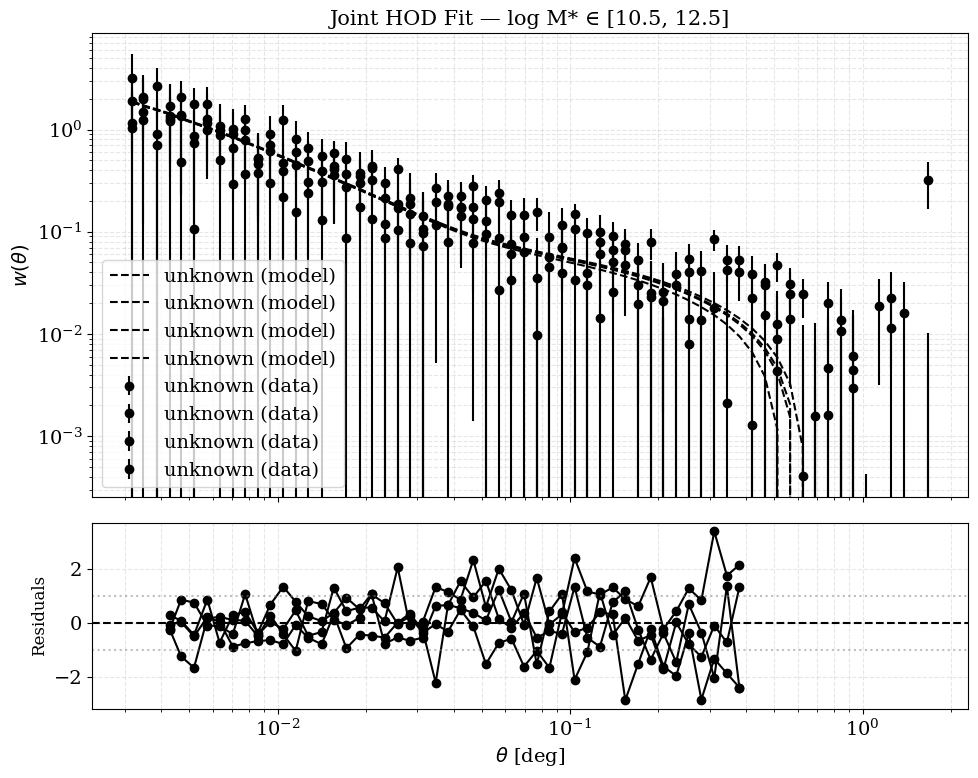

In [38]:
all_results = {sm_range: {} for sm_range in SM_bins}

# Start SM bin loop
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")

    # Use first field to define shared theta grid
    first_field = list(fields.keys())[0]
    fpaths = fields[first_field]

    # Clean science + mask + join
    fits_file_path = os.path.join(thesis_path, fpaths["catalog"])
    fcat = clean_catalog(fits_file_path)
    masked_file_path= os.path.join(thesis_path, fpaths["masked"])
    fmask = clean_catalog(masked_file_path)
    fcat = join(fcat, fmask, keys='id')

    fcat.rename_column('mode_z','z')
    fcat.rename_column('mode_mass','SM')

    # Clean randoms
    fits_random = os.path.join(thesis_path, fpaths["randoms"])
    frand = clean_catalog(fits_random)

    # Selection and reference theta grid
    first_sub = dv.Selection(fcat, frand, z_min, z_max, SM_min, SM_max, config)
    shared_theta = np.array(first_sub.theta)

    # storage
    field_selections = []
    bias_eff_dict = {}
    sm_by_field, halo_by_field = {}, {}

    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")

        # Clean science + mask + join
        cat = clean_catalog(os.path.join(thesis_path, paths["catalog"]))
        mask = clean_catalog(os.path.join(thesis_path, paths["masked"]))
        cat = join(cat, mask, keys='id')

        cat.rename_column('mode_z','z')
        cat.rename_column('mode_mass','SM')

        # Clean randoms
        rand = clean_catalog(os.path.join(thesis_path, paths["randoms"]))

        # Apply selection
        sub = dv.Selection(cat, rand, z_min, z_max, SM_min, SM_max, config)

        # Force consistent θ-grid
        interp_w = interp1d(sub.theta, sub.w_theta, kind='linear',
                            bounds_error=False, fill_value="extrapolate")
        interp_var = interp1d(sub.theta, sub.var_w_theta_bootstrap, kind='linear',
                              bounds_error=False, fill_value="extrapolate")

        sub.w_theta = interp_w(shared_theta)
        sub.var_w_theta_bootstrap = interp_var(shared_theta)
        sub.theta = shared_theta

        field_selections.append(sub)
        bias_eff_dict[field] = sub.gg.bias_effective_tracer


    fitter = MultiFieldHODFitter(field_selections)

    hod_params, pcov = fitter.fit(
        p0=[12.59*1e-7, 13.97, 1.],
        bounds=([11.0*1e-7, 13., 0.99], [14.5*1e-7, 15.5, 1.01])
    )

    logM_min, logM_1, alpha = hod_params
    print(f"\n✅ Joint HOD best-fit: logM_min = {logM_min*1e7:.2f}, "
          f"logM_1 = {logM_1:.2f}, alpha = {alpha:.2f}")

    all_results[(SM_min, SM_max)] = {
        'field_selections': field_selections,
        'hod_params': hod_params,
        'pcov': pcov,
        'bias_eff': bias_eff_dict
    }

    plot_joint_fit(field_selections, colors, SM_min, SM_max, shared_theta)


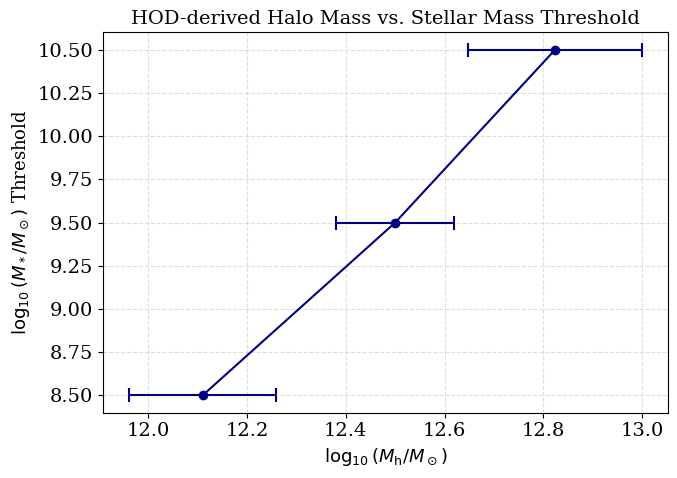

In [42]:

sm_thresholds = []
mmin_values = []
mmin_errs = []

for (SM_min, SM_max), result in all_results.items():
    if result.get('hod_params') is None or result.get('pcov') is None:
        continue  # Skip if missing fits

    logM_min = result['hod_params'][0]     
    logM_min = logM_min * 1e7

    
    # Extract error on logM_min from covariance matrix
    pcov = result['pcov']
    logM_min_err = np.sqrt(pcov[0][0]) * 1e7 if pcov is not None else 0

    sm_thresholds.append(SM_min)
    mmin_values.append(logM_min)
    mmin_errs.append(logM_min_err)

plt.figure(figsize=(7, 5))

plt.errorbar(mmin_values, sm_thresholds,xerr=mmin_errs,fmt='o-', color='navy', capsize=5, capthick=1.5)
plt.xlabel(r'$\log_{10}(M_{\mathrm{h}}/M_\odot)$', fontsize=13)
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$ Threshold', fontsize=13)

plt.title('HOD-derived Halo Mass vs. Stellar Mass Threshold', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()

plt.show()


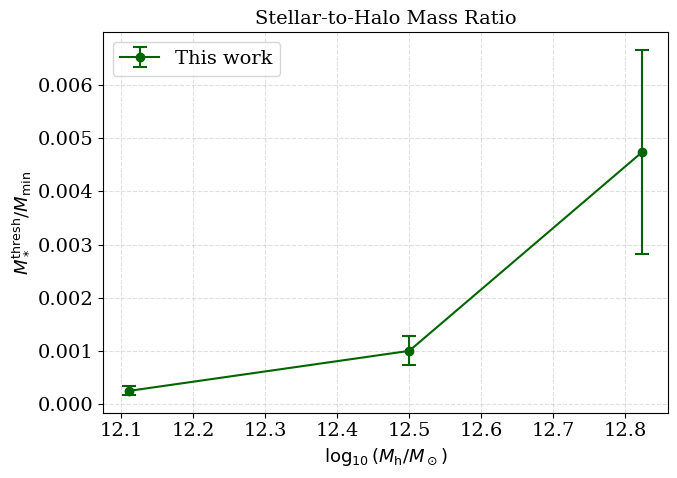

In [43]:
sm_thresholds = []
shmr_values = []
shmr_errs = []
mmin_values = []
mmin_errs = []

for (SM_min, SM_max), result in all_results.items():
    if result.get('hod_params') is None or result.get('pcov') is None:
        continue  # Skip if missing fits

    logM_min = result['hod_params'][0] 
    logM_min = logM_min * 1e7
    pcov = result['pcov']
    
    # Compute SHMR
    shmr = 10**(SM_min - logM_min) # SM_min is also in log btw
    
    # Extract error on logM_min from covariance matrix (index 0,0)
    logM_min_err = np.sqrt(pcov[0][0]) * 1e7 if pcov is not None else 0
    
    # Propagate error to SHMR
    shmr_err = shmr * logM_min_err * np.log(10)
    
    sm_thresholds.append(SM_min)
    mmin_values.append(logM_min)
    mmin_errs.append(logM_min_err)
    shmr_values.append(shmr)
    shmr_errs.append(shmr_err)
plt.figure(figsize=(7, 5))

plt.errorbar(mmin_values, shmr_values, yerr=shmr_errs, fmt='o-', color='darkgreen', capsize=5, capthick=1.5,label='This work' )


 

plt.xlabel(r'$\log_{10}(M_{\mathrm{h}}/M_\odot)$', fontsize=13)
plt.ylabel(r'$M_*^{\mathrm{thresh}} / M_{\mathrm{min}}$', fontsize=13)
plt.title('Stellar-to-Halo Mass Ratio', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.legend()

plt.savefig("Mh_vs_SMHR")

plt.show()


In [45]:
Mhalo = [
    66296706817.30795, 73917898798.73352, 82415191117.65851, 91889296602.63226, 102452505607.51738,
    114230016915.3509, 127361421637.34383, 142002357694.69983, 158326354492.74042, 176526889651.04785,
    196819682166.6986, 219445249189.9458, 244671756716.13455, 272798197981.23068, 304157937232.3985,
    339122660875.61456, 378106782830.6767, 421572356307.3892, 470034550218.98444, 524067755141.1132,
    584312391186.3297, 651482498483.3376, 726374200225.966, 809875138598.8401, 902974995417.5806,
    1006777222177.7738, 1122512118541.2837, 1251551414270.6223, 1395424527441.4702, 1555836691631.2769,
    1734689166933.6006, 1934101774346.0808, 2156438020617.3528, 2404333111341.2197, 2680725184318.9062,
    2988890133377.9307, 3332480435391.469, 3715568440689.3813, 4142694639953.733, 4618921479674.62,
    5149893364005.711, 5741903554181.688, 6401968758413.307, 7137912296323.953, 7958456823622.604,
    8873327716016.268, 9893368337705.371, 11030668560661.88, 12298708057947.068, 13712516069428.059,
    15288849533494.11, 17046391696047.846, 19005973550756.92, 21190820735148.2, 2404333111341.2197
]

Mcent_50 = [
    138185889.15720302, 172720900.0668386, 215673222.45576337, 269089919.88765955, 335515179.327528,
    418111484.28001314, 520828269.08945644, 648606120.6643087, 807610719.2412863, 1005539328.3203484,
    1252045100.3530602, 1559341768.9483867, 1942821473.3047915, 2421887213.518848, 3020837737.8737206,
    3768184888.123724, 4697571006.331157, 5849459111.900749, 7272065288.372202, 9012562604.540678,
    11103654734.995914, 13563337202.82329, 16383512911.519424, 19526092461.489563, 22964843744.2323,
    26653770811.350174, 30497339591.234303, 34332934621.112762, 38039137854.068245, 41580202752.4853,
    44960629691.55288, 48255164000.67649, 51559726515.37951, 54848574060.27377, 58074904513.471115,
    61195354453.304756, 64176275624.11628, 66982124975.57955, 69594247688.89069, 72041324787.95726,
    74431053359.4038, 76855424127.0457, 79317242371.72003, 81830017335.21799, 84437227153.89256,
    87197196144.7057, 90094865412.7629, 93078040073.30054, 96062580938.40805, 98928121262.40611,
    101605473415.01775, 104098955603.05504, 106479288961.97887, 108926724434.02715, 131113681632.74998
]

Mcent_16 = [
    122859549.08492075, 153463093.1277725, 191768882.6401075, 239526223.76712334, 298836177.16694885,
    372219547.2840017, 463052304.6707711, 575984089.142209, 717040702.2843549, 894038906.9945077,
    1116606899.1893206, 1395243177.6998365, 1742212577.8122094, 2171990261.733003, 2701881404.0431743,
    3356430344.5712314, 4169195559.5823936, 5183738595.810069, 6456409992.04091, 8037261534.242731,
    9941610303.771763, 12155006203.772999, 14615543931.667683, 17212255517.138123, 19873379026.627617,
    22520938757.34364, 25036248827.990265, 27250495293.425167, 29045929842.63774, 30407827062.838898,
    31407366014.24033, 32259098525.92094, 33224153465.373096, 34332008079.68556, 35556722949.82484,
    36839738462.00549, 38087147941.07143, 39256742347.15974, 40349198016.17066, 41392236424.72836,
    42456861702.30304, 43598950121.40022, 44811201739.4774, 46072871679.93738, 47348448049.77223,
    48595493415.716606, 49803988231.3955, 50986747058.85586, 52185980770.76462, 53483597074.1377,
    54927179481.6141, 56525638200.18852, 58283289227.600975, 60197536524.2768, 75233860276.46657
]

Mcent_84 = [
    151841683.43116438, 188804430.35792825, 234528445.9761902, 291627479.4423529, 363603417.5064963,
    455136384.68409896, 571674824.6189399, 719219189.8050666, 905012812.7288473, 1137794075.4261613,
    1428466573.0027277, 1791676007.004955, 2246154632.081757, 2815655554.5198855, 3529882573.2354293,
    4421325003.19453, 5525535085.792659, 6882740897.502729, 8537251211.159791, 10529464663.453302,
    12883561796.396748, 15602388043.97047, 18652262648.43852, 21963348732.300957, 25508669710.572273,
    29268192338.128353, 33203775236.438942, 37254202425.78185, 41370327876.53652, 45531477775.037155,
    49735616340.65336, 54015845050.07054, 58416390418.72675, 62921318405.1627, 67510561839.025604,
    72179252980.06393, 76942390560.4907, 81778926561.5444, 86648244541.48576, 91518589845.90186,
    96379988758.53552, 101225557692.34584, 106043833293.65878, 110866749981.52075, 115806777285.15465,
    121023457392.73651, 126511325700.39758, 132197429787.67732, 137965749705.99323, 143650476583.49664,
    149129962573.3049, 154348609108.23242, 159305987750.48944, 164101459416.9993, 195683907020.22842
]

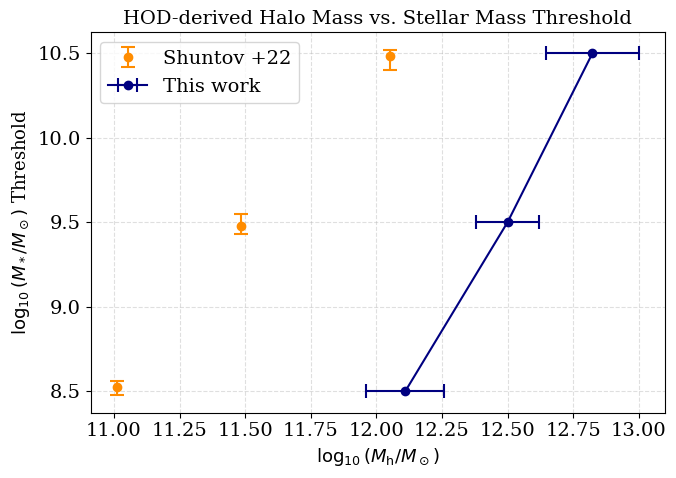

In [46]:

Mhalo = np.array(Mhalo).flatten()       # flatten to 1D
Mcent_50 = np.array(Mcent_50).flatten()
Mcent_16 = np.array(Mcent_16).flatten()
Mcent_84 = np.array(Mcent_84).flatten()

# Convert to log10 scale
log_Mhalo = np.log10(Mhalo)
log_Mcent_50 = np.log10(Mcent_50)
log_Mcent_16 = np.log10(Mcent_16)
log_Mcent_84 = np.log10(Mcent_84)

y_err_lower = log_Mcent_50 - log_Mcent_16
y_err_upper = log_Mcent_84 - log_Mcent_50
y_err = np.array([y_err_lower, y_err_upper])

# Define stellar mass thresholds (log scale)
thresholds = np.array([8.5, 9.5, 10.5])

# Find indices of points closest to these thresholds
indices = [np.argmin(np.abs(log_Mcent_50 - t)) for t in thresholds]

# Select the points and errors at these indices
x_points = log_Mhalo[indices]
y_points = log_Mcent_50[indices]
y_err_points = y_err[:, indices]

plt.figure(figsize=(7, 5))

# Plot the three selected points with error bars
plt.errorbar(x_points, y_points, yerr=y_err_points, fmt='o', color='darkorange', capsize=5, capthick=1.5, label='Shuntov +22')
plt.errorbar(mmin_values, sm_thresholds,xerr=mmin_errs,fmt='o-', color='navy', capsize=5, capthick=1.5,label='This work' )


plt.xlabel(r'$\log_{10}(M_{\mathrm{h}}/M_\odot)$', fontsize=13)
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$ Threshold', fontsize=13)

plt.title('HOD-derived Halo Mass vs. Stellar Mass Threshold', fontsize=14)
plt.grid(True, ls='--', alpha=0.4)
plt.legend()
plt.savefig("SM_Mh_with_Shuntov")
plt.tight_layout()
plt.show()